# Predicting product rating based on review text 

## Project in LTAT.01.001 Natural language processing

#### Team members: Karl Jaagup Kask, Ludvig Leis, Richard Nõmm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


!python3 -m nltk.downloader stopwords
!python3 -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
RANDOM_SEED = 100

The data we are using: https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products

## Data preprocessing (data file needs to be imported)

In [ ]:
df = pd.read_csv('amazon_review_dataset.csv') #renamed

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = df[df['reviews.rating'].notnull() & df['reviews.text'].notnull()]
df= df[['reviews.rating','reviews.text']]

df.rename(columns = {'reviews.rating':'rating', 'reviews.text':'text'}, inplace = True)
df['text'][0]

'This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.'

In [ ]:
stops = stopwords.words('english')

remove_punc = re.compile('[^a-z]+')
def clean_text(sent):
    sent = str(sent).lower()
    sent = remove_punc.sub(' ', sent).strip()
    filtered = [word for word in sent.split() if word not in stops]
    sentence = " ".join(filtered) #just joined -> laused
    #sentence = nltk.word_tokenize(sentence) #tokenized -> listid
    return sentence

clean_text(df['text'][0])


'product far disappointed children love use like ability monitor control content see ease'

In [ ]:
reviews = [clean_text(sent) for sent in df['text']]

In [ ]:
df['text'] = reviews
df['text']

0        product far disappointed children love use lik...
1        great beginner experienced person bought gift ...
2        inexpensive tablet use learn step nabi thrille...
3        fire hd two weeks love tablet great value prim...
4        bought grand daughter comes visit set user ent...
                               ...                        
34655    appreciably faster higher amp charger used kin...
34656    amazon include charger kindle fact charging us...
34657    love kindle fire really disappointed kindle po...
34658    surprised find come type charging cords purcha...
34659    spite fact nothing good things say amazon anth...
Name: text, Length: 34626, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


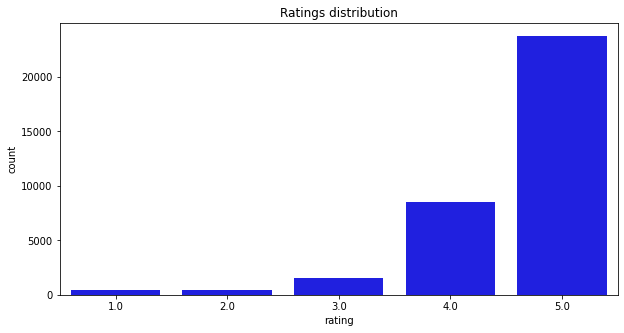

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['rating'], color= "blue")
plt.title('Ratings distribution')
plt.show()

## I Naive-Bayes approach

## BERT approach

The following code is based on this notebook: https://colab.research.google.com/drive/1f32gj5IYIyFipoINiC8P3DvKat-WWLUK 



In [ ]:
!pip install transformers
!pip install conllu

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
import time
import random
from collections import Counter
from typing import List, Dict

# Check if we are running on a CPU or GPU, should be GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import AutoModelForTokenClassification, AdamW, AutoConfig
from transformers import AutoTokenizer, PreTrainedTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from conllu import parse

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print(device)

     |████████████████████████████████| 2.3MB 4.2MB/s 
     |████████████████████████████████| 901kB 26.9MB/s 
     |████████████████████████████████| 3.3MB 38.0MB/s 



cuda


In [ ]:
# Function for tokenizing texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=160,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True,      # Return attention mask
            truncation=True
            )
  
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
from sklearn.model_selection import train_test_split

# Create train & val data (80%)
X = df.text.values[:int(len(df.text)*0.8)]
y = df.rating.values [:int(len(df.text)*0.8)]

# Split train & val data
X_train, X_val0, y_train, y_val0 =\
    train_test_split(X, y, test_size=0.2, random_state=100)

X_val, X_test, y_val, y_test = train_test_split(X_val0, y_val0, test_size=0.5, random_state=100)

In [ ]:
print(len(X_train))
print(len(y_train))
print(X_train)

22160
22160
['easy use kids daughter happy play favorite games'
 'purchased tablet year old twin grandchildren also purchased protective cover absolutely love'
 'learn talk properly things wemo better reviewed' ...
 'conclude enough look read specs'
 'amazon echo began basically speaker music waited started getting features skills bought glad actually bought echo dots first mainly home automation skills decided get big echo leave kitchen use skills listen music works great speaker decent quality'
 'week purchase item went sale think best buy refund difference without drive minutes way return repurchase store advised call like credit card information']


In [ ]:
# Tokenize data
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(train_inputs)
print(train_masks)

tensor([[  101,  3733,  2224,  ...,     0,     0,     0],
        [  101,  4156, 13855,  ...,     0,     0,     0],
        [  101,  4553,  2831,  ...,     0,     0,     0],
        ...,
        [  101, 16519,  2438,  ...,     0,     0,     0],
        [  101,  9733,  9052,  ...,     0,     0,     0],
        [  101,  2733,  5309,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.Tensor(y_train)
val_labels = torch.Tensor(y_val)
test_labels = torch.Tensor(y_test)

train_labels = train_labels.type(torch.LongTensor)
val_labels = val_labels.type(torch.LongTensor)
test_labels = test_labels.type(torch.LongTensor)
# Chosed batch size is 16.

batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels 
        # Nr or labels is 6, because 0 (not used), 1,2,3,4,5 (ratings).
        D_in, H, D_out = 768, 50, 6

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 68 µs, sys: 0 ns, total: 68 µs
Wall time: 75.6 µs


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    model = BertClassifier(freeze_bert=False)
   
    # Tell PyTorch to run the model on GPU
    model.to(device)
    
   # model = BertForSequenceClassification.from_pretrained(
   # "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    #num_labels = 6, # Five ratings  
    #output_attentions = False, # Whether the model returns attentions weights.
    #output_hidden_states = False, # Whether the model returns all hidden-states.)

    # Tell pytorch to run this model on the GPU.
    #model.to(device)
    # Create the optimizer
    optimizer = AdamW(model.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return model, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()
            
            
            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_losses.append(val_loss)
            val_accs.append(val_accuracy)
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

    return train_losses, val_losses, val_accs


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
torch.cuda.empty_cache()
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
losses, val_losses, val_accs = train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.286518   |     -      |     -     |   17.30  
   1    |   40    |   1.043634   |     -      |     -     |   16.41  
   1    |   60    |   1.059592   |     -      |     -     |   16.48  
   1    |   80    |   0.893126   |     -      |     -     |   16.50  
   1    |   100   |   1.015187   |     -      |     -     |   16.53  
   1    |   120   |   0.927563   |     -      |     -     |   16.53  
   1    |   140   |   0.908194   |     -      |     -     |   16.56  
   1    |   160   |   0.959522   |     -      |     -     |   16.56  
   1    |   180   |   0.899646   |     -      |     -     |   16.57  
   1    |   200   |   0.949802   |     -      |     -     |   16.54  
   1    |   220   |   0.905522   |     -      |     -     |   16.56  
   1    |   240   |   0.973388   |     -      |     -     |   16.56  


[0.8528074987743736, 0.7234456114928215, 0.6058316338363537]
[0.7310103430658922, 0.7227223515510559, 0.7730723133032349]
[69.32471264367815, 70.6896551724138, 69.82758620689656]


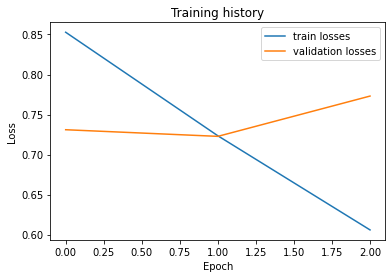

In [ ]:
print(losses)
print(val_losses)
print(val_accs)
vals = []

for val in val_accs:
  vals.append(val/100)
plt.plot(losses, label='train losses')
plt.plot(val_losses, label='validation losses')
#plt.plot(vals, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

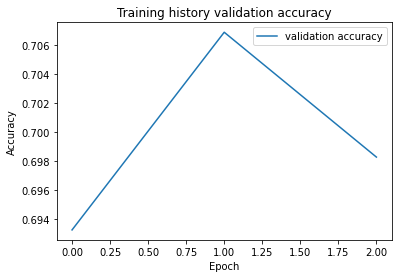

In [ ]:
plt.plot(vals, label='validation accuracy')
plt.title('Training history validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

Evaluation on test data

In [ ]:
# Evaluate the Bert classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
probs = bert_predict(bert_classifier, test_dataloader)
preds=[]
for i in probs:
  arg = np.argmax(i)
  preds.append(arg)

accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 68.84%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[  11    0    7    4    3]
 [   1    0    9   12    4]
 [   7    0   18   55   27]
 [   6    1   34  274  459]
 [   3    0   11  220 1604]]


              precision    recall  f1-score   support

         1.0       0.39      0.44      0.42        25
         2.0       0.00      0.00      0.00        26
         3.0       0.23      0.17      0.19       107
         4.0       0.48      0.35      0.41       774
         5.0       0.76      0.87      0.82      1838

    accuracy                           0.69      2770
   macro avg       0.37      0.37      0.37      2770
weighted avg       0.66      0.69      0.67      2770



In [ ]:
idx = 99 #just a sample value

review_text = X_test[idx]
print(review_text)
true_rating = y_test[idx]
print(true_rating)

pred_df = preds[idx]
print(pred_df)

second tablet great starter tablet prime account even better prime video allows download videos later viewing
5.0
5


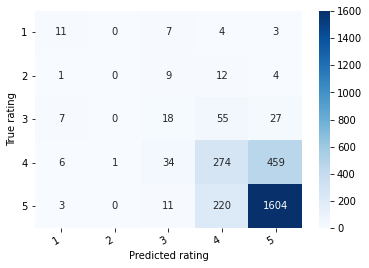

In [ ]:
def show_conf_matrix(confusion_matrix):
  hmap =sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha ='right')
  plt.ylabel('True rating')
  plt.xlabel('Predicted rating')

ratings = [1,2,3,4,5]

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index = ratings, columns = ratings)
show_conf_matrix(df_cm)